# Building a Probabilistic Matching Engine


In this notebook, we will show how to build a probabilistic matching engine.  This approach is used for record matching or deduplication of a dataset.  In this notebook, we will try to link records for the same person.  This is not necessarily a straightforward process since a person's address, name, phone number, etc. can change over time.  


**Steps**

1. Create matching dataset - we will need to formulate the data so that there is one record comparing two people 
2. Calculate string distances between the attributes of two people
3. Build machine learning models to predict if two people are a match
4. Use model to predict matches

## Step 1: Create Matching Dataset

In order to treat this problem as a supervised learning problem, we need a target column.  In this case, we will assume that people were being matched by hand and we have some historical data that indicates whether two people were found to be a match.  The benefit of using a machine learning model to identify matches in the future is that the process can now be done automatically on huge datasets.

The end result of our dataset should be something like this: 


| rec_id_orig | given_name_orig | surname_orig | rec_id_dup | given_name_dup | surname_dup | is_match |
|-------------|-----------------|--------------|------------|----------------|-------------|----------|
| 1070        | michaela        | neumann      | 1016       | courtney       | painter     | False    |
| 1070        | michaela        | neumann      | 1016       | courtney       | painter     | False    |
| 1070        | michaela        | neumann      | 4405       | charles        | green       | False    |
| 1070        | michaela        | neumann      | 1016       | michaela       | jakimow     | True     |

We will use the `recordlinkage` package to load the data we will use during this tutorial.  Two datasets are loaded - the original records and the duplicates.  The `rec_id` tells us if they are matches.  

In [245]:
import recordlinkage
from recordlinkage.datasets import load_febrl4

orig, dup = load_febrl4()

In [246]:
orig.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
rec-1288-org,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,19951119,9239102
rec-3585-org,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688


In [247]:
dup.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-561-dup-0,elton,NaN,3,light setreet,pinehill,windermere,3212,vic,19651013,1551941
rec-2642-dup-0,mitchell,maxon,47,edkins street,lochaoair,north ryde,3355,nsw,19390212,8859999
rec-608-dup-0,NaN,white,72,lambrigg street,kelgoola,broadbeach waters,3159,vic,19620216,9731855
rec-3239-dup-0,elk i,menzies,1,lyster place,NaN,northwood,2585,vic,19980624,4970481
rec-2886-dup-0,NaN,garanggar,NaN,may maxwell crescent,springettst arcade,forest hill,2342,vic,19921016,1366884


In [248]:
# clean the rec_id so they match

orig = orig.reset_index()
orig.rec_id = orig.rec_id.str.replace("rec-", "").str.replace("-org", "")

dup = dup.reset_index()
dup.rec_id = dup.rec_id.str.replace("rec-", "").str.replace("-dup-\d", "")

orig.head()

,rec_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
0,1070,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
1,1016,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
2,4405,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
3,1288,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,19951119,9239102
4,3585,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688


Once we have the data from the `recordlinkage` package we will start to use H2O. We will be using H2O for the rest of this tutorial with the assumption that this data could be very large and would require a scalable solution.

In [249]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.2" 2019-07-16; Java(TM) SE Runtime Environment (build 12.0.2+10); Java HotSpot(TM) 64-Bit Server VM (build 12.0.2+10, mixed mode, sharing)
  Starting server from /Users/megankurka/env2/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpmvb989wd
  JVM stdout: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpmvb989wd/h2o_megankurka_started_from_python.out
  JVM stderr: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpmvb989wd/h2o_megankurka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_megankurka_s70525
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


In [250]:
# convert data to H2O
orig_hf = h2o.H2OFrame(orig)
dup_hf = h2o.H2OFrame(dup)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [251]:
orig_hf.head()

rec_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
1070,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,1.91511e+07,5.30422e+06
1016,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,1.91612e+07,4.06662e+06
4405,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,1.94809e+07,4.36517e+06
1288,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,1.99511e+07,9.2391e+06
3585,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,1.98602e+07,7.20769e+06
298,blake,howie,1,cutlack street,belmont park belted galloway stud,budgewoi,6017,vic,1.92503e+07,5.18055e+06
1985,nan,lund,109,caley crescent,allandale aged care facility,mill park,4053,nsw,1.91809e+07,7.07469e+06
2404,blakeston,broadby,53,traeger street,valley of springs,north ward,3083,qld,1.91209e+07,4.30856e+06
1473,nan,leslie,925,carpenter close,nan,canterbury,2340,vic,1.99506e+07,2.43806e+06
453,edward,denholm,10,corin place,gold tyne,clayfield,4221,vic,1.96603e+07,7.11977e+06


We change the column names of our frames to indicate if the attribute belongs to the original or a possible duplicate.

In [252]:
orig_hf.col_names = ["{}_orig".format(i) for i in orig_hf.col_names]
dup_hf.col_names = ["{}_dup".format(i) for i in dup_hf.col_names]

Since each record in our modeling data will be a pair of people, we need to merge the original and duplicates together.  We will first merge all the matches together (the original and duplicate are the same person).

In [254]:
# merge all matches
matching_hf = orig_hf.merge(dup_hf, all_x=True, by_x=["rec_id_orig"], by_y=["rec_id_dup"])
matching_hf["rec_id_dup"] = matching_hf["rec_id_orig"]

In [255]:
matching_hf.head()

rec_id_orig,given_name_orig,surname_orig,street_number_orig,address_1_orig,address_2_orig,suburb_orig,postcode_orig,state_orig,date_of_birth_orig,soc_sec_id_orig,given_name_dup,surname_dup,street_number_dup,address_1_dup,address_2_dup,suburb_dup,postcode_dup,state_dup,date_of_birth_dup,soc_sec_id_dup,rec_id_dup
0,rachael,dent,1,knox street,lakewood estate,byford,4129,vic,1.92807e+07,1.68399e+06,rachael,dent,4,knox street,lakewood estate,byford,4129,vic,1.92807e+07,1.68399e+06,0
1,isabella,everett,25,pike place,rowethorpe,marsden,2152,nsw,1.91108e+07,6.65313e+06,isabella,everett,25,pike mlace,rowethorpe,marsden,2152,nsw,1.91108e+07,6.65313e+06,1
2,olivia,trigwell,13,waldock street,wilpena,new lambton heights,3194,vic,1.95711e+07,9.99175e+06,olivia,trigwell,13,waldock street,wilpena,newlambto nheights,3194,vic,1.95711e+07,9.99175e+06,2
3,reeve,stanley,4,alawa street,rowethorpe d1,mourilyan,2474,sa,1.91908e+07,5.96167e+06,reeve,stanlhy,4,alawa street,rowethorpe d1,mourilyan,2474,sa,1.91908e+07,5.96167e+06,3
4,jayde,crouch,42,weston street,waimaru,niagara park,2119,wa,1.92504e+07,8.8927e+06,ja yde,crouch,42,westo atreet,waimaru,niagara park,2119,wa,1.92504e+07,8.8927e+06,4
5,josephine,yu,145,hensman street,lambar,burwood,6164,wa,1.91109e+07,5.79234e+06,josephine,yu,145,hensman street,lambar,burwood,6164,wa,1.93109e+07,5.79234e+06,5
6,holly,petersen,13,marou place,never die,birkdale,6530,nsw,1.92712e+07,9.50079e+06,holy,petersen,13,marou place,never die,birkdale,6530,nsw,1.92712e+07,9.50079e+06,6
7,jasmine,silvestro,41,nott street,tathra river est,middleton beach,3173,nsw,1.95607e+07,9.87395e+06,angus,silvestro,41,nott street,tathra river est,middleton beach,3137,nsw,1.95607e+07,9.87395e+06,7
8,nicholas,procter,1,cavanaugh street,sherwood,leeville,2089,nsw,1.90312e+07,2.66227e+06,nicholas,procter,1,cavanaughlstreet,sherwood,leevflle,2089,nsw,1.90312e+07,2.66227e+06,8
9,paris,reid,39,crowder circuit,nan,st ives,3225,vic,1.99808e+07,2.55331e+06,paris,reid,39,crowder circuit,nan,st ives,3225,vic,1.99808e+07,2.54331e+06,9


We now need to create our non-matching pairs.  We do not want to compare all possibilities - this will result in a very large frame.  Instead, we will randomly select 10% of the non-matching records to pair up.  In our case, this means that for every matching pair, there will be 500 non-matching pairs that have been randomly selected.

In [256]:
# merge 10% of non-matches
from random import sample 
non_match_count = round(orig_hf.nrow * 0.1)

orig_ids = list(orig_hf["rec_id_orig"].unique().as_data_frame().C1.values)
dup_ids = list(dup_hf["rec_id_dup"].unique().as_data_frame().C1.values)
non_match_indices = [pd.DataFrame({'rec_id_orig': [i]*non_match_count, 'rec_id_dup': sample(dup_ids, non_match_count)}) 
                     for i in orig_ids]
non_match_indices = pd.concat(non_match_indices)

non_match_indices.head()

,rec_id_orig,rec_id_dup
0,0,3736
1,0,2441
2,0,1914
3,0,4528
4,0,525


In [257]:
non_match_indices_hf = h2o.H2OFrame(non_match_indices)
non_matching_hf = non_match_indices_hf.merge(orig_hf, all_x = True)
non_matching_hf = non_matching_hf.merge(dup_hf, all_x = True)
non_matching_hf = non_matching_hf[non_matching_hf["rec_id_orig"] < non_matching_hf["rec_id_dup"]]

Parse progress: |█████████████████████████████████████████████████████████| 100%


Now we combine our matching and non-matching pairs and add our `is_match` column.

In [258]:
model_hf = matching_hf.rbind(non_matching_hf[matching_hf.col_names])
model_hf["is_match"] = (model_hf["rec_id_orig"] == model_hf["rec_id_dup"]).asfactor()

In [269]:
model_hf.head()

rec_id_orig,given_name_orig,surname_orig,street_number_orig,address_1_orig,address_2_orig,suburb_orig,postcode_orig,state_orig,date_of_birth_orig,soc_sec_id_orig,given_name_dup,surname_dup,street_number_dup,address_1_dup,address_2_dup,suburb_dup,postcode_dup,state_dup,date_of_birth_dup,soc_sec_id_dup,rec_id_dup,is_match,given_name_jw,surname_jw,address_1_jw,address_2_jw,suburb_jw,state_jw
0,rachael,dent,1,knox street,lakewood estate,byford,4129,vic,1.92807e+07,1.68399e+06,rachael,dent,4,knox street,lakewood estate,byford,4129,vic,1.92807e+07,1.68399e+06,0,1,1,1,1,1,1,1
1,isabella,everett,25,pike place,rowethorpe,marsden,2152,nsw,1.91108e+07,6.65313e+06,isabella,everett,25,pike mlace,rowethorpe,marsden,2152,nsw,1.91108e+07,6.65313e+06,1,1,1,1,0.96,1,1,1
2,olivia,trigwell,13,waldock street,wilpena,new lambton heights,3194,vic,1.95711e+07,9.99175e+06,olivia,trigwell,13,waldock street,wilpena,newlambto nheights,3194,vic,1.95711e+07,9.99175e+06,2,1,1,1,1,1,0.974756,1
3,reeve,stanley,4,alawa street,rowethorpe d1,mourilyan,2474,sa,1.91908e+07,5.96167e+06,reeve,stanlhy,4,alawa street,rowethorpe d1,mourilyan,2474,sa,1.91908e+07,5.96167e+06,3,1,1,0.942857,1,1,1,1
4,jayde,crouch,42,weston street,waimaru,niagara park,2119,wa,1.92504e+07,8.8927e+06,ja yde,crouch,42,westo atreet,waimaru,niagara park,2119,wa,1.92504e+07,8.8927e+06,4,1,0.955556,1,0.952564,1,1,1
5,josephine,yu,145,hensman street,lambar,burwood,6164,wa,1.91109e+07,5.79234e+06,josephine,yu,145,hensman street,lambar,burwood,6164,wa,1.93109e+07,5.79234e+06,5,1,1,1,1,1,1,1
6,holly,petersen,13,marou place,never die,birkdale,6530,nsw,1.92712e+07,9.50079e+06,holy,petersen,13,marou place,never die,birkdale,6530,nsw,1.92712e+07,9.50079e+06,6,1,0.953333,1,1,1,1,1
7,jasmine,silvestro,41,nott street,tathra river est,middleton beach,3173,nsw,1.95607e+07,9.87395e+06,angus,silvestro,41,nott street,tathra river est,middleton beach,3137,nsw,1.95607e+07,9.87395e+06,7,1,0.561905,1,1,1,1,1
8,nicholas,procter,1,cavanaugh street,sherwood,leeville,2089,nsw,1.90312e+07,2.66227e+06,nicholas,procter,1,cavanaughlstreet,sherwood,leevflle,2089,nsw,1.90312e+07,2.66227e+06,8,1,1,1,0.975,1,0.95,1
9,paris,reid,39,crowder circuit,nan,st ives,3225,vic,1.99808e+07,2.55331e+06,paris,reid,39,crowder circuit,nan,st ives,3225,vic,1.99808e+07,2.54331e+06,9,1,1,1,1,1,1,1


In [259]:
model_hf["is_match"].table()

is_match,Count
0,1.2487e+06
1,5000



## Step 2: Calculating String Distances

Now that we have our pairs data, we will calculate the distances between the attributes.  We will calculate the string distances using the JaroWinkler edit distance.

In [260]:
str_cols = ["given_name", "surname", "address_1", "address_2", "suburb", "state"]

jw_dist = model_hf[["{}_orig".format(i) for i in str_cols]].strdistance(model_hf[["{}_dup".format(i) for i in str_cols]], measure = "jw")
jw_dist.col_names = ["{}_jw".format(i) for i in str_cols]

model_hf = model_hf.cbind(jw_dist)

In [261]:
model_hf[["given_name_orig", "given_name_dup", "given_name_jw"]].head()

given_name_orig,given_name_dup,given_name_jw
rachael,rachael,1
isabella,isabella,1
olivia,olivia,1
reeve,reeve,1
jayde,ja yde,0.955556
josephine,josephine,1
holly,holy,0.953333
jasmine,angus,0.561905
nicholas,nicholas,1
paris,paris,1


## Step 3: Build Machine Learning Models

Now that we have our string distances, we can build a model to predict `is_match`. 

We will begin by splitting our data by the original record id. This means that the test data will not consist of any original records shown in the training dataset.

In [262]:
# Split data into training and testing by unique rec_id_orig
train = model_hf[model_hf["rec_id_orig"] <= 3750, :]
test = model_hf[model_hf["rec_id_dup"] > 3750, :]

In [263]:
predictors = jw_dist.col_names
response = "is_match"

We use H2O-3's AutoML to search the algorithm and parameter space.

In [268]:
from h2o.automl import H2OAutoML

automl = H2OAutoML(seed=1234,
                   max_models=5 # only run 5 models for demo purposes
                  )
automl.train(y=response, x=predictors, training_frame=train, leaderboard_frame=test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [270]:
automl.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_2_AutoML_20200921_211508,0.999993,0.00013396,0.998608,0.00440994,0.00536296,2.87613e-05
XGBoost_1_AutoML_20200921_211508,0.999988,0.000143596,0.998239,0.00560632,0.00527494,2.78249e-05
StackedEnsemble_AllModels_AutoML_20200921_211508,0.999982,0.000230711,0.998223,0.00400687,0.00498066,2.4807e-05
StackedEnsemble_BestOfFamily_AutoML_20200921_211508,0.999982,0.000250168,0.998168,0.00400778,0.00539656,2.91229e-05
XGBoost_3_AutoML_20200921_211508,0.999981,0.000123187,0.998625,0.00400595,0.00488688,2.38816e-05
GLM_1_AutoML_20200921_211508,0.999773,0.0004538,0.991616,0.0144408,0.00979893,9.60191e-05
DRF_1_AutoML_20200921_211508,0.998789,0.000227962,0.996032,0.00400412,0.00503093,2.53102e-05


Our best model is an XGBoost model. We can see from the confusion matrix that it has very low error in predicting matches.

In [271]:
xgb = automl.leader

In [274]:
xgb.model_performance(test).confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5371371507644653: 


,,0,1,Error,Rate
0,0,545814.0,7.0,0.0,(7.0/545821.0)
1,1,11.0,1238.0,0.0088,(11.0/1249.0)
2,Total,545825.0,1245.0,0.0,(18.0/547070.0)


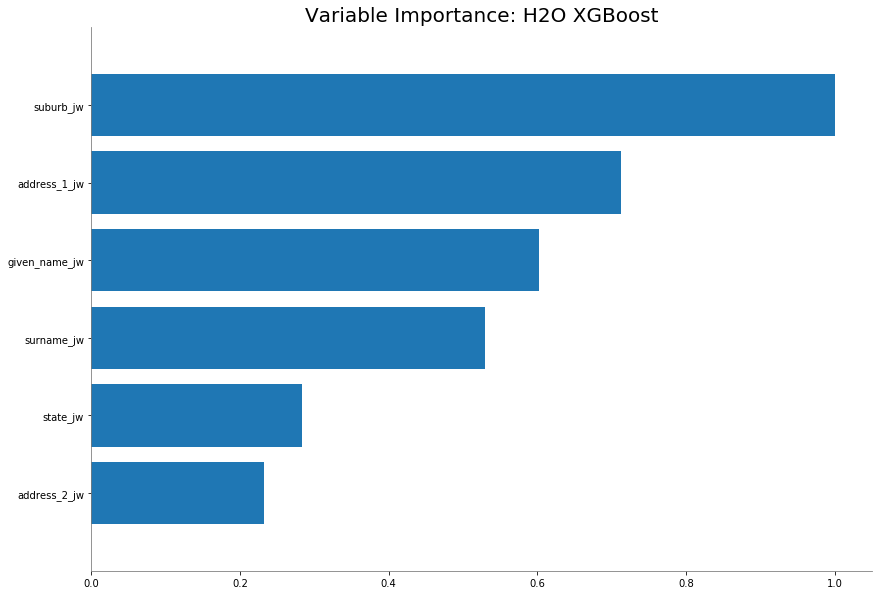

In [272]:
%matplotlib inline
xgb.varimp_plot()

We can see from the partial dependence plots that the greater the similarity between these attributes, the more likely the two people are the same.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependencePlot progress: |█████████████████████████████████████████| 100%


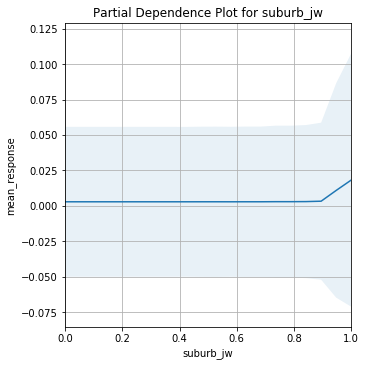

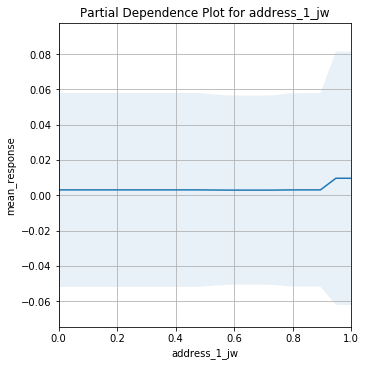

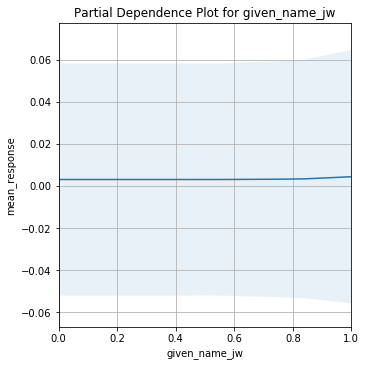

In [277]:
xgb.partial_plot(train, cols=["suburb_jw"], figsize=(5,5));
xgb.partial_plot(train, cols=["address_1_jw"], figsize=(5,5));
xgb.partial_plot(train, cols=["given_name_jw"], figsize=(5,5));

## Step 4: Predict Matches

Now that we have built and selected our matching model, we can use it to determine which two people are matches.

In [340]:
def predict_match(model, orig_record, data, str_cols, threshold=0.5):
    
    # create pairs of data
    orig_record.col_names = ["{}_orig".format(i) for i in orig_record.col_names]
    orig_record["merge_col"] = 1
    
    data = h2o.deep_copy(data, xid="original_data_copy")
    data.col_names = ["{}_dup".format(i) for i in data.col_names]
    data["merge_col"] = 1
    
    matching_data = orig_record.merge(data, all_y=True)
    
    # calculate string distances
    jw_dist = matching_data[["{}_orig".format(i) for i in str_cols]].strdistance(matching_data[["{}_dup".format(i) for i in str_cols]], measure = "jw")
    jw_dist.col_names = ["{}_jw".format(i) for i in str_cols]
    matching_data = matching_data.cbind(jw_dist)
    
    preds = model.predict(matching_data)
    matches = matching_data[preds["p1"] > threshold, data.col_names]
    
    return matches
    
    

In [333]:
full_data = h2o.H2OFrame(orig).rbind(h2o.H2OFrame(dup))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


We ask H2O who matches our first record:

In [335]:
full_data[0, :]

rec_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
1070,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,1.91511e+07,5.30422e+06


Our model returns two matches.  From the record id, we can see that they are both actual matches.  

In [341]:
predict_match(xgb, full_data[0, :], full_data, str_cols)

xgboost prediction progress: |████████████████████████████████████████████| 100%


rec_id_dup,given_name_dup,surname_dup,street_number_dup,address_1_dup,address_2_dup,suburb_dup,postcode_dup,state_dup,date_of_birth_dup,soc_sec_id_dup,merge_col
1070,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,1.91511e+07,5.30422e+06,1
1070,michafla,jakimow,8,stanleykstreet,miami,winstonbhills,4223,nan,1.91511e+07,5.30422e+06,1


In [343]:
h2o.cluster().shutdown()

H2O session _sid_ad03 closed.
